In [1]:
import os
import numpy as np
import pickle
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from behavenet.fitting.utils import get_lab_example
from behavenet.fitting.utils import get_output_dirs
from behavenet.fitting.utils import get_output_session_dir
from behavenet.fitting.utils import get_subdirs

save_outputs = False
results_dir = '/home/mattw/results/behavenet_figs/'

# 1. Plot decoder performance by region for a single session

### load results

In [2]:
from behavenet.data.utils import get_region_list
from behavenet.fitting.utils import get_subdirs

# specify decoder directory
hparams = {
    'data_dir': '/home/mattw/data/',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet/',
    'n_ae_latents': 16,
    'subsample_regions': 'single',
    'lab': 'musall',
    'expt': 'vistrained',
    'animal': 'mSM30',
    'session': '10-Oct-2017',
    'multisession': None}

model_types = ['linear', 'ff']  # keep both
model_class = 'neural-ae'  # 'neural-ae' | 'neural-arhmm'
expt_name = 'grid_search'

region_names = get_region_list(hparams)

metrics = []
model_indx = 0
model_counter = 0
for region in region_names:
    hparams['region'] = region
    for model_type in model_types:

        hparams['n_arhmm_states'] = 8
        get_lab_example(hparams, hparams['lab'])

        hparams['session_dir'], _ = get_output_session_dir(hparams)
        _, expt_dir = get_output_dirs(
            hparams, model_class=model_class, expt_name=expt_name, model_type=model_type)

        # gather all versions
        try:
            versions = get_subdirs(expt_dir)
        except Exception:
            print('No models in %s; skipping' % expt_dir)

        # load csv files with model metrics (saved out from test tube)
        for i, version in enumerate(versions):
            # read metrics csv file
            model_dir = os.path.join(expt_dir, version)
            try:
                metric = pd.read_csv(os.path.join(model_dir, 'metrics.csv'))
                model_counter += 1
            except:
                continue
            # load model info
    #         with open(os.path.join(model_dir, 'meta_tags.csv'), mode='r') as f:
    #             hp = csv.reader(f)
    #             hparams = {rows[0]: rows[1] for rows in hp}
            with open(os.path.join(model_dir, 'meta_tags.pkl'), 'rb') as f:
                hparams = pickle.load(f)
            # append model info to metrics ()
            version_num = version[8:]
            metric['version'] = str('version_%i' % model_indx + version_num)
            metric['region'] = region
            for key, val in hparams.items():
                if isinstance(val, (str, int, float)):
                    metric[key] = val
            metrics.append(metric)

        model_indx += 10000  # assumes no more than 10k model versions in an experiment
# put everything in pandas dataframe
metrics_df = pd.concat(metrics, sort=False)
print('Loaded %i models for analysis' % model_counter)

Loaded 4125 models for analysis


### Plot model performance as a function of lags/layers 
### (take best models over learning rate/L2 reg)

In [3]:
# for each version, only keep rows where test_loss is not nan
data_queried = metrics_df[pd.notna(metrics_df.test_loss)]
best_models_list = []
   
# take min over val losses
loss_mins = metrics_df.groupby(
    ['n_lags', 'n_hid_layers', 'learning_rate', 'l2_reg', 'version', 'region']) \
    .min().reset_index()
n_lags = metrics_df.n_lags.unique()
n_lags.sort()
n_hid_layers = metrics_df.n_hid_layers.unique()
n_hid_layers.sort()
regions = metrics_df.region.unique()
regions.sort()
for region in regions:
    for lag in n_lags:
        for layer in n_hid_layers:
            # get all models with this number of lags
            single_hp = loss_mins[
                (loss_mins.n_lags==lag) 
                & (loss_mins.n_hid_layers==layer)
                & (loss_mins.region==region)]
            # find best version from these models
            best_version = loss_mins.iloc[single_hp.val_loss.idxmin()].version
#             print('{}, {}, {}, {}'.format(region, lag, layer, best_version))
            # index back into original data to grab test loss on all batches
            best_models_list.append(data_queried[data_queried.version==best_version])

best_models_df = pd.concat(best_models_list)

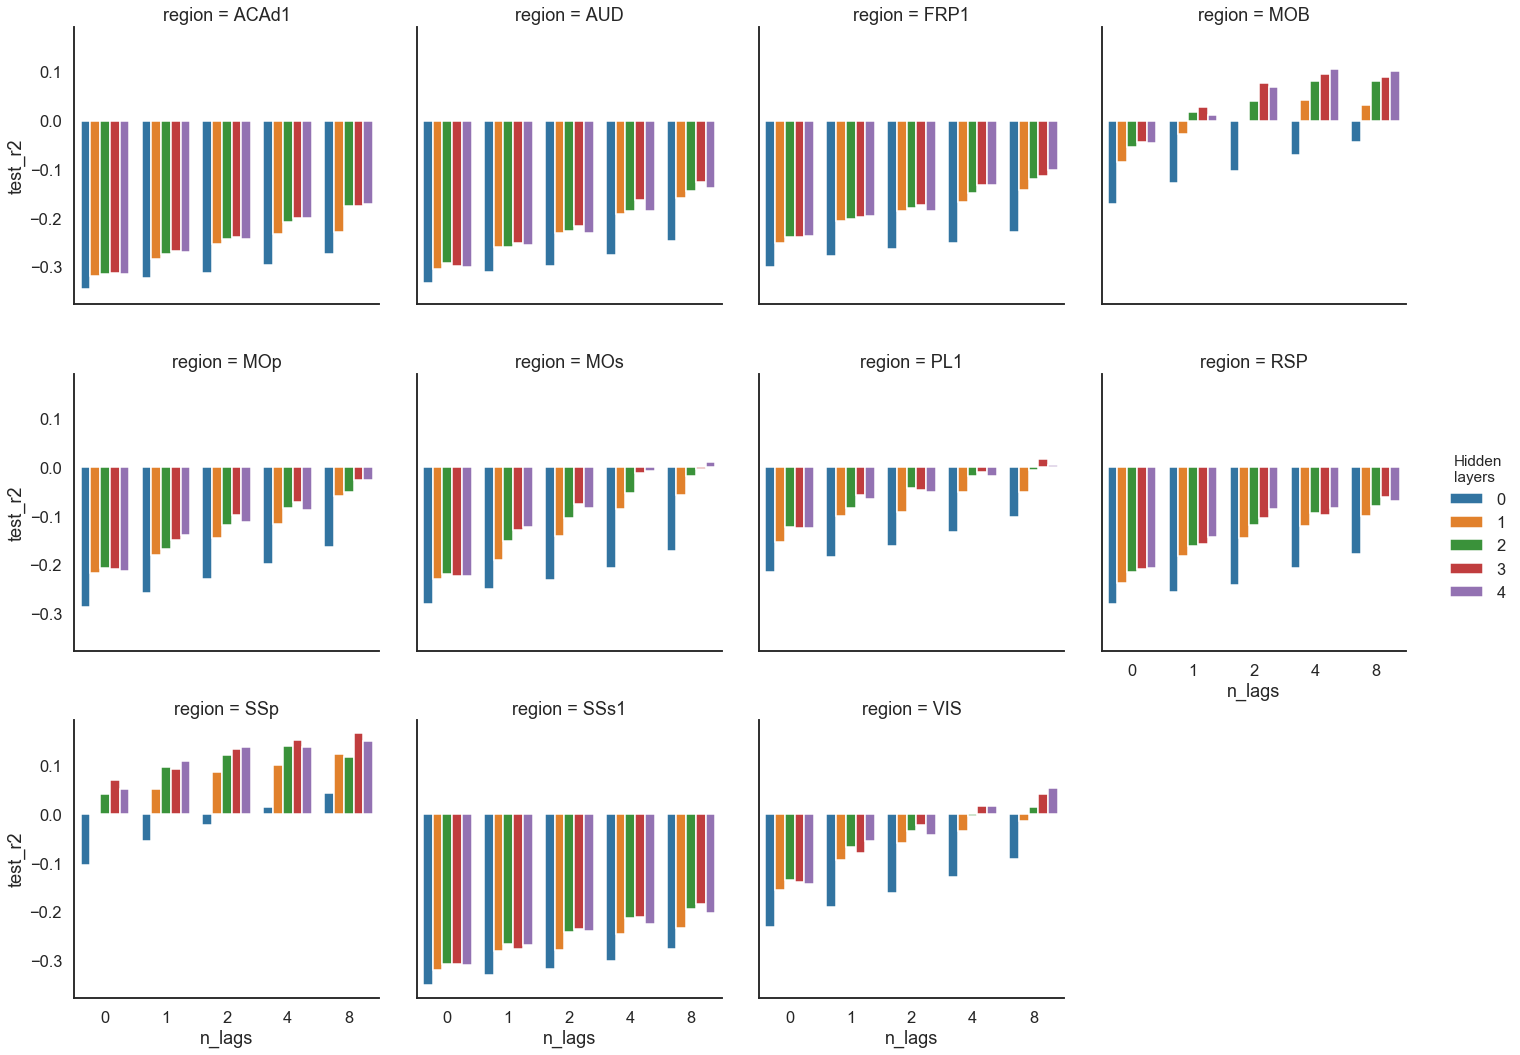

In [4]:
# PLOT
sns.set_style('white'); sns.set_context('talk')
if model_class == 'neural-ae':
    y_axis = 'test_r2' # 'test_loss' | 'test_r2'
    meas_str = 'R2'
    plot_type = 'bar'
elif model_class == 'neural-arhmm':
    y_axis = 'test_fc'
    meas_str = 'FC'
    plot_type = 'boxen'
hue = None if 'ff' not in model_types else 'n_hid_layers'
splt = sns.catplot(
    x='n_lags', y=y_axis, hue=hue, col='region', col_wrap=4,
    kind=plot_type, data=best_models_df, ci=None)
if hue is not None:
    splt._legend.set_title('Hidden\nlayers')
plt.show()

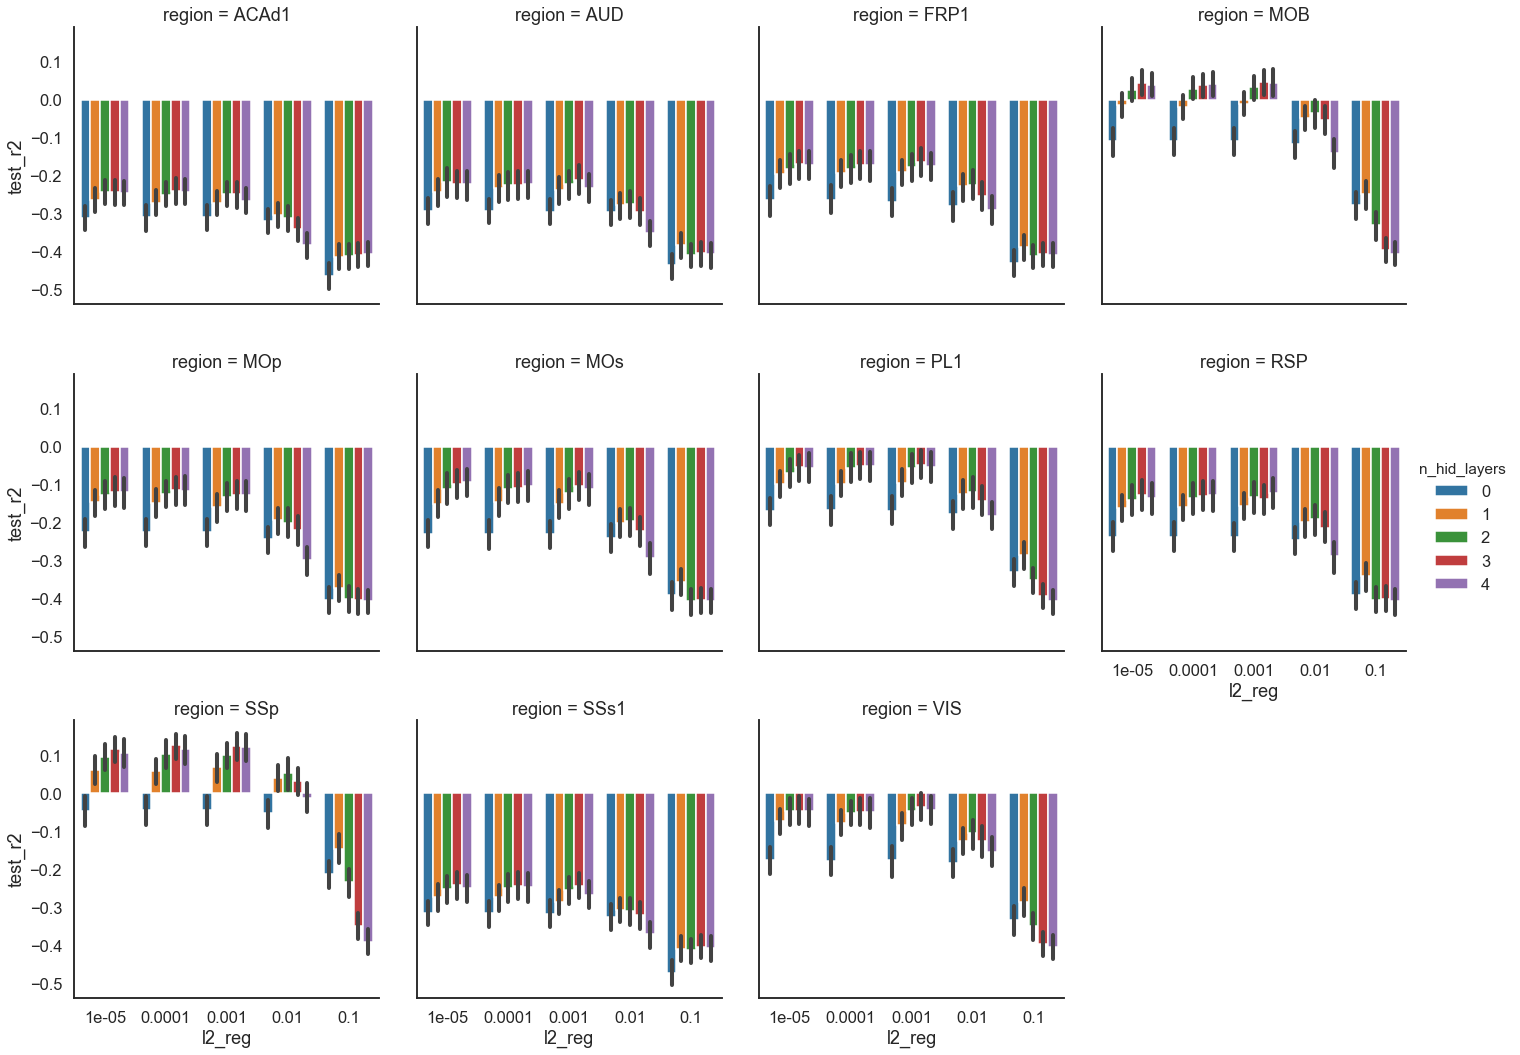

In [5]:
# look at reg vals/learning rate
measure = 'l2_reg'  # 'learning_rate' | 'l2_reg'
get_best = 'l2_reg' if measure == 'learning_rate' else 'learning_rate'
    
# for each version, only keep rows where test_loss is not nan
data_queried = metrics_df[pd.notna(metrics_df.test_loss)]

# group by get_best, find avgs over all other hyperparams
best_meas = data_queried.groupby([get_best]).mean().reset_index()
# find the best value for get_best
best_meas = best_meas[
    best_meas['test_loss']==best_meas['test_loss'].min()][get_best].values[0]
# subsample data with this value
data_queried = data_queried[data_queried[get_best]==best_meas]

splt = sns.catplot(
    x=measure, y='test_r2', hue='n_hid_layers', kind='bar', col='region', 
    col_wrap=4, data=data_queried)

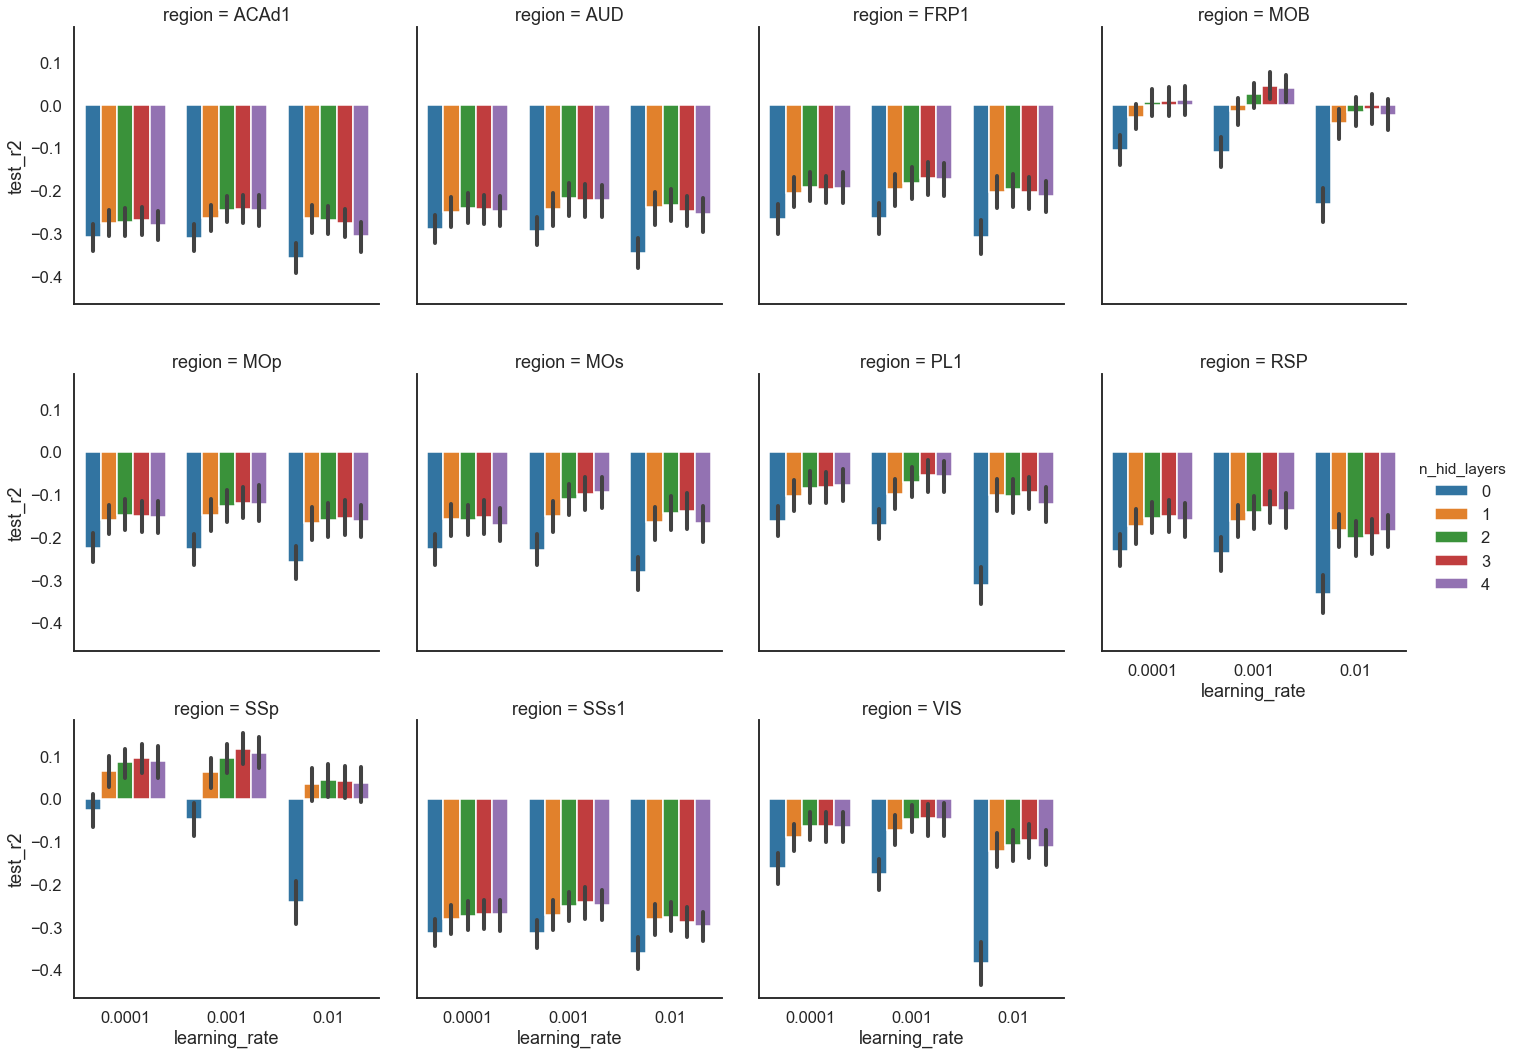

In [6]:
# look at reg vals/learning rate
measure = 'learning_rate'  # 'learning_rate' | 'l2_reg'
get_best = 'l2_reg' if measure == 'learning_rate' else 'learning_rate'
    
# for each version, only keep rows where test_loss is not nan
data_queried = metrics_df[pd.notna(metrics_df.test_loss)]

# group by get_best, find avgs over all other hyperparams
best_meas = data_queried.groupby([get_best]).mean().reset_index()
# find the best value for get_best
best_meas = best_meas[
    best_meas['test_loss']==best_meas['test_loss'].min()][get_best].values[0]
# subsample data with this value
data_queried = data_queried[data_queried[get_best]==best_meas]

splt = sns.catplot(
    x=measure, y='test_r2', hue='n_hid_layers', kind='bar', col='region', 
    col_wrap=4, data=data_queried)

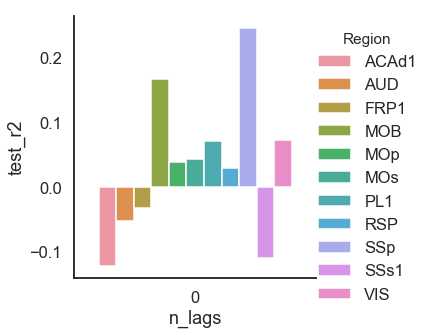

In [22]:
sns.set_style('white'); sns.set_context('talk')
data_queried = metrics_df[pd.notna(metrics_df.test_loss)]
data_queried = data_queried \
    .groupby('version')['region', 'test_r2', 'n_lags'] \
    .agg({'region': pd.Series.mode, 'test_r2': 'median', 'n_lags': lambda x: 0}) \
    .reset_index()
data_queried = data_queried \
    .groupby('region')['test_r2', 'n_lags'].agg('max').reset_index()
splt = sns.catplot(
    x='n_lags', y='test_r2', hue='region', kind='bar', data=data_queried)
# splt.ax.set_ylabel('$R^2$')
# splt.ax.set_xlabel('Neural lags')
if hue is not None:
    splt._legend.set_title('Region')
if save_outputs:
    save_file = os.path.join(results_dir, '%s_decoder_R2s_across_trials' % lab)
else:
    save_file = None
if save_file is not None:
    plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')   
plt.show()

# 1A. Calculate $R^2$/FC over entire test data for a single session

### get best models from before

In [8]:
from behavenet.fitting.eval import get_test_r2

versions = best_models_df.version.unique()

hparams = {
    'data_dir': '/home/mattw/data/',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet/',
    'experiment_name': 'grid_search',
    'model_class': 'neural-ae',
    'n_max_lags': 8,
    'subsample_regions': 'single',
    'lab': 'musall',
    'expt': 'vistrained',
    'animal': 'mSM30',
    'session': '10-Oct-2017',
    'multisession': None}
hparams['model_class'] = 'neural-ae'
get_lab_example(hparams, hparams['lab'])

all_test_r2s = []
for version in versions:
    model_version = str(int(version[8:]) % 10000)
    hparams['model_type'] = best_models_df[
            best_models_df.version==version].model_type.unique()[0]
    hparams['region'] = best_models_df[
            best_models_df.version==version].region.unique()[0]
    hparams_, r2 = get_test_r2(hparams, model_version)
    all_test_r2s.append(pd.DataFrame({
        'region': hparams['region'],
        'n_hid_layers': hparams_['n_hid_layers'],
        'n_lags': hparams_['n_lags'],
        'r2': r2}, index=[0]))
all_test_r2s_df = pd.concat(all_test_r2s)

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/linear/ACAd1-single/test_tube_data/grid_search/version_2/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_16/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_6/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_23/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/ACAd1-single/test_tube_data/grid_search/version_28/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_197/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_207/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_210/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/AUD-single/test_tube_data/grid_search/version_204/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/linear/FRP1-single/test_tube_data/grid_search/version_20/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_185/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_187/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_188/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/linear/MOB-single/test_tube_data/grid_search/version_71/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/MOB-single/test_tube_data/grid_search/version_211/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/1

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_233/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_234/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/linear/MOs-single/test_tube_data/grid_search/version_53/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_14/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/MOs-single/test_tube_data/grid_search/version_15/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_99/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/linear/RSP-single/test_tube_data/grid_search/version_42/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_121/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_122/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/RSP-single/test_tube_data/grid_search/version_118/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/linear/SSs1-single/test_tube_data/grid_search/version_30/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_56/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_132/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_3/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/16_latents/ff/SSs1-single/test_tube_data/grid_search/version_90/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/neural-ae/

### plot by lags/layers across all regions

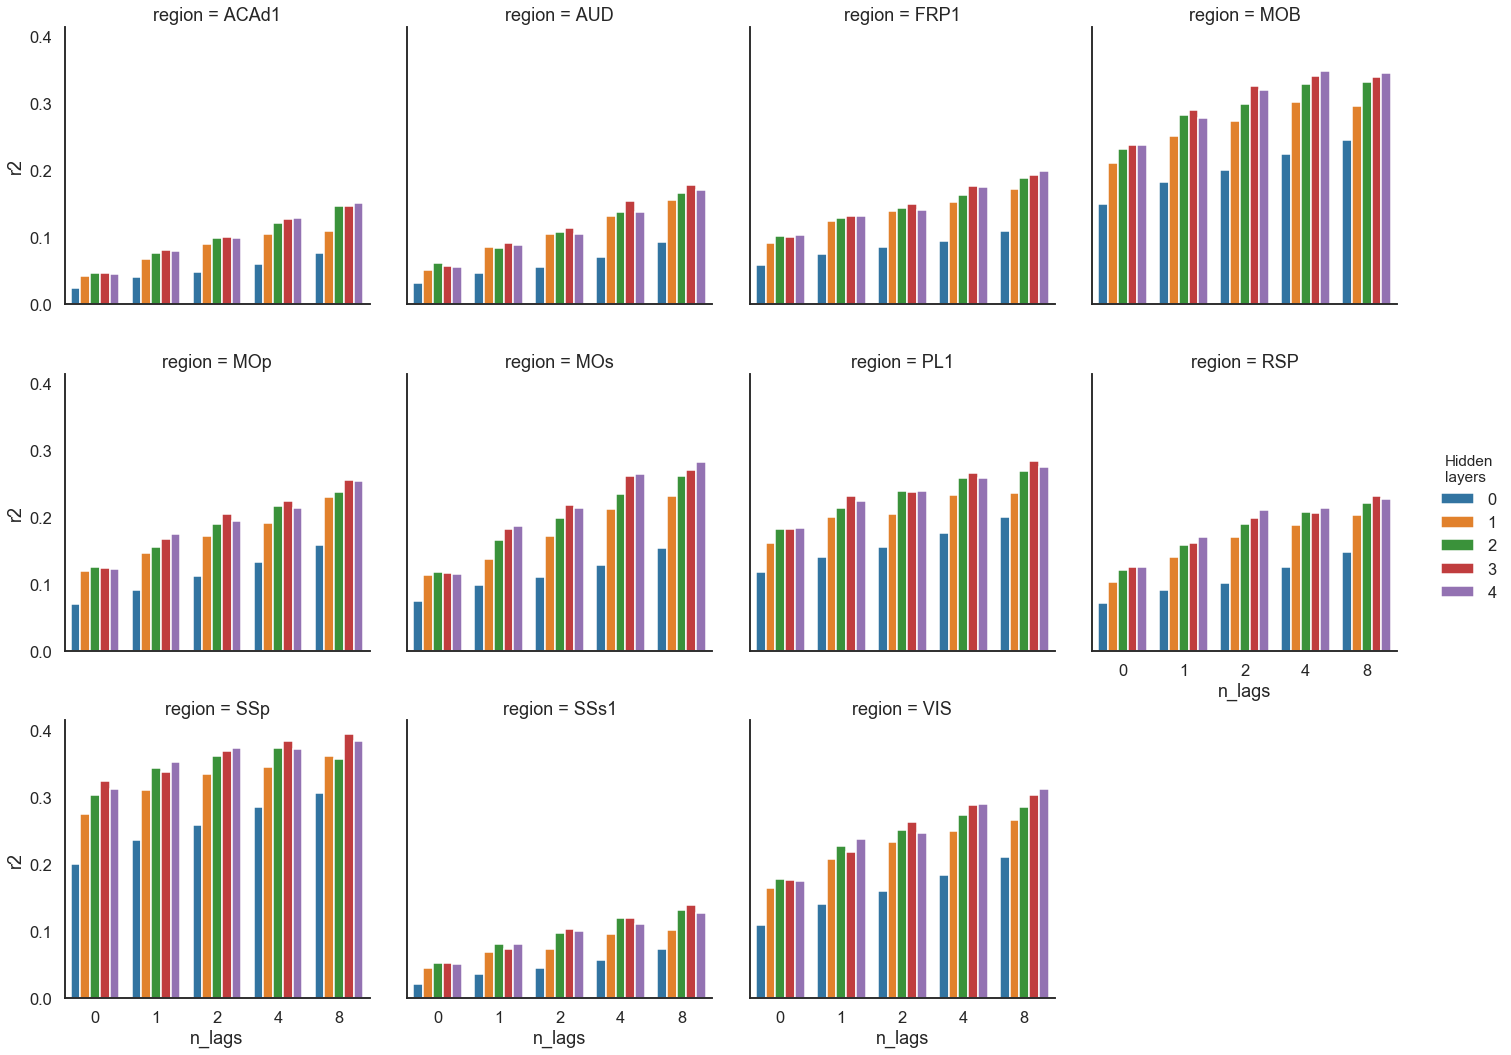

In [9]:
sns.set_style('white'); sns.set_context('talk')
splt = sns.catplot(
    x='n_lags', y='r2', hue='n_hid_layers', col='region', col_wrap=4,
    kind='bar', data=all_test_r2s_df)
# splt.ax.set_ylabel('$R^2$')
# splt.ax.set_xlabel('Neural lags')
splt._legend.set_title('Hidden\nlayers')
# splt.ax.set_ylim([-0.1, 0.2])
if save_outputs:
    save_file = os.path.join(results_dir, '%s_decoder_R2s_across_trials' % lab)
else:
    save_file = None   
if save_file is not None:
    plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')
plt.show()

### plot best model for each region

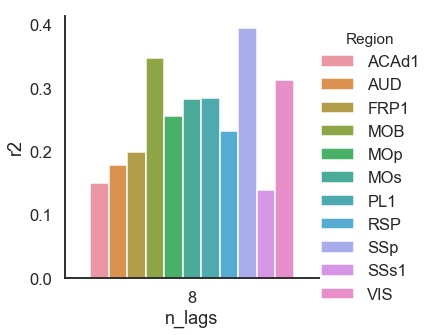

In [10]:
sns.set_style('white'); sns.set_context('talk')
data_queried = all_test_r2s_df.groupby('region').max().reset_index()
splt = sns.catplot(
    x='n_lags', y='r2', hue='region', kind='bar', data=data_queried)
# splt.ax.set_ylabel('$R^2$')
# splt.ax.set_xlabel('Neural lags')
splt._legend.set_title('Region')
# splt.ax.set_ylim([-0.1, 0.2])
if save_outputs:
    save_file = os.path.join(results_dir, '%s_decoder_R2s_across_trials' % lab)
else:
    save_file = None
if save_file is not None:
    plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')    
plt.show()